<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# Pronóstico 3: Ecuación Diferencial Estocástica Lineal en Sentido Estricto con Nivel de Tendencia Funcional

## 1. Análisis del proceso de reversión a la media con tendencia funcional

La **reversión a la media** es un concepto estadístico que sostiene que los precios y los retornos eventualmente volverán hacia el promedio o la media. Este comportamiento es típico en sistemas donde las fluctuaciones aleatorias provocan desviaciones temporales de un nivel medio persistente.

### Descripción del proceso

En el contexto de una **ecuación diferencial estocástica (EDS)** con tendencia funcional, el término de reversión a la media se modifica para incluir una función que representa esta tendencia. Matemáticamente, puede modelarse como:


    $ dX_t = \kappa (\theta(t) - X_t) dt + \sigma dW_t $

donde:
- \(X_t\) es el estado del proceso en el tiempo \(t\).
- \(\kappa\) es la velocidad de reversión hacia la media.
- \(\theta(t)\) es la tendencia funcional, que puede ser una función del tiempo.
- \(\sigma\) es el coeficiente de volatilidad del proceso.
- \(dW_t\) es el incremento de un movimiento browniano estándar.

### Condiciones para la asignación a datos

Para utilizar esta ecuación de manera efectiva, es necesario que:
- Los datos deben mostrar un comportamiento de reversión a una tendencia que pueda modelarse como función del tiempo.
- Debe ser posible estimar de forma fiable los parámetros \(\kappa\), \(\sigma\), y la función \(\theta(t)\).
- Los residuos del modelo deben comportarse como ruido blanco, indicando que toda la información relevante ha sido capturada por el modelo.

### Aplicaciones de las variantes

Las variantes de la reversión a la media con tendencia funcional se aplican en diversos campos como:
- **Economía financiera:** para modelar tasas de interés, tipos de cambio, y precios de commodities.
- **Ciencias ambientales:** en modelos de calidad del aire o temperaturas, donde se espera que regresen a un nivel medio influenciado por factores estacionales.
- **Ingeniería:** en el control de procesos donde las variables deben mantenerse dentro de rangos deseables a pesar de perturbaciones externas.

## Objetivo

El objetivo de analizar y utilizar este tipo de ecuación es poder predecir y entender el comportamiento dinámico de sistemas que exhiben una tendencia central alterada por influencias funcionales, permitiendo una mejor toma de decisiones basada en modelos matemáticos estocásticos.


# 2.  Descargue los datos alguna variable clim´atica de alguna región de Europa
GREECE

Station: AKTIO

Element: Maximum temperature

Period : 1979-2023

Blending : no
```



In [ ]:
# Se corre una vez al abrir una nueva sesión
!pip install arch

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pylab as plt
from arch.unitroot import ADF
from scipy.optimize import curve_fit
from IPython.display import display, Math
from astropy.convolution import convolve, Box1DKernel

import seaborn as sns # gráficas
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings("ignore")

# 3. EDEL en Sentido Estricto con Nivel de Tendencia Funcional

## **Datos**

Se descargaron los datos de https://www.ecad.eu/dailydata/index.php


*   **Estación:**  máximas de Aktio Grecia
*




In [ ]:
with open('/content/ECA_non-blended_custom/TX_SOUID119992.txt', 'r') as file:
    lines = file.readlines()
data = [line.strip().split(',') for line in lines]
data = [line for line in data if len(line) == 5 and line[0][0].isdigit()]
column_names = ['STAID', 'SOUID', 'DATE', 'TX', 'Q_TX']
df = pd.DataFrame(data, columns=column_names)
df = df.astype({'STAID': int, 'SOUID': int, 'DATE': int, 'TX': int, 'Q_TX': int})
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

In [ ]:
df_2016_2020 = df[(df["DATE"] >= "2019-01-01") & (df["DATE"] <= "2023-01-02")]
data = df_2016_2020
mid = len(df_2016_2020 )//2
data1= df_2016_2020 [:mid]
data2 = df_2016_2020 [mid:]
train = df_2016_2020 [:mid]
test = df_2016_2020 [mid:]

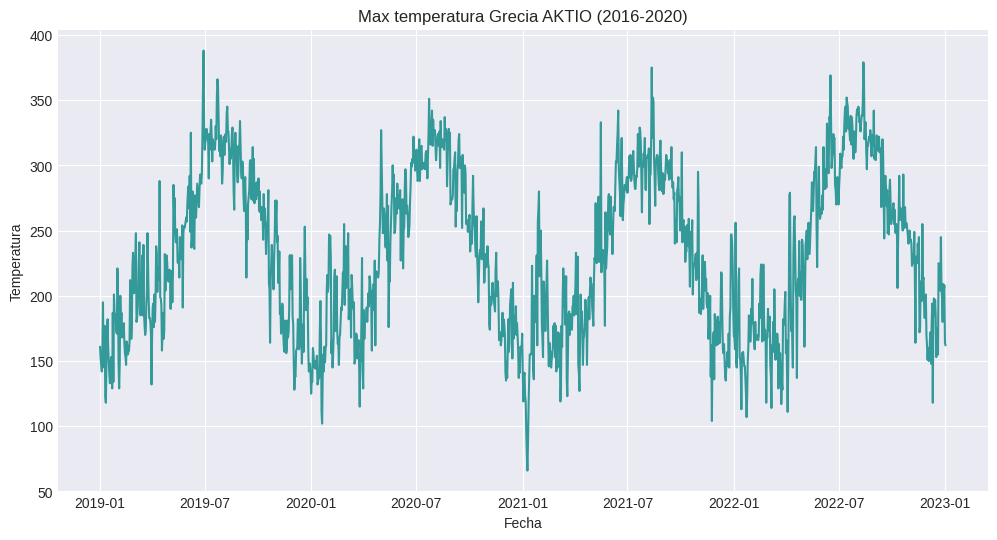

In [ ]:
# Visualizar

plt.figure(figsize=(12, 6))
plt.plot(df_2016_2020['DATE'], df_2016_2020['TX'],color=(0.2,0.6,0.6))
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Max temperatura Grecia AKTIO (2016-2020)')
plt.savefig('Serie_clima_pron3.png')
plt.show()

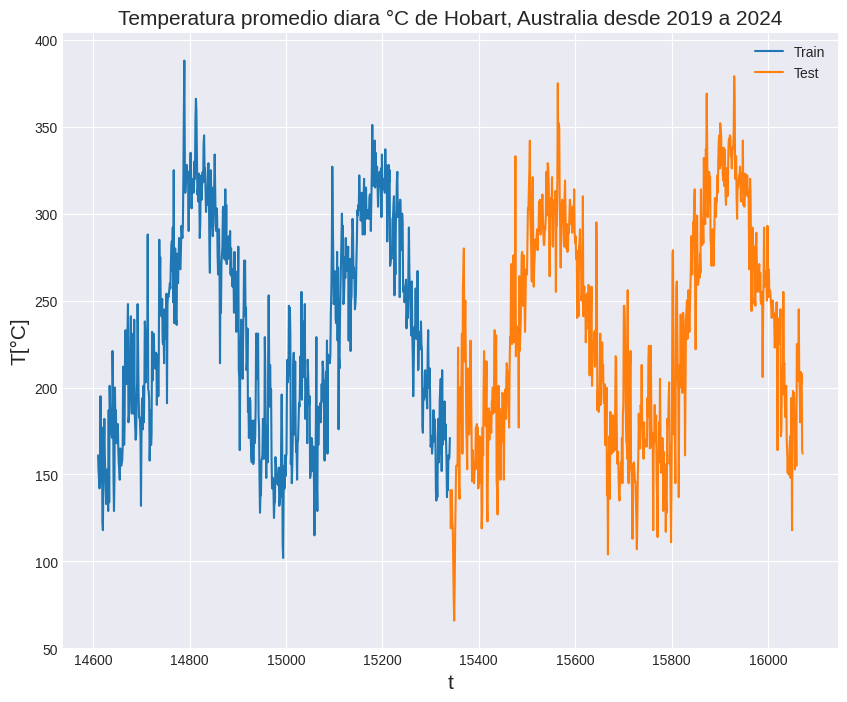

In [ ]:
plt.figure(figsize=(10,8))
train['TX'].plot();
test['TX'].plot();
title = r'Temperatura promedio diara °C de Hobart, Australia desde 2019 a 2024'
plt.title(title, fontsize = 15);
plt.xlabel('t', fontsize = 15);
plt.ylabel('T[°C]', fontsize = 15);
plt.legend(['Train','Test']);
train= train['TX']
test = test['TX']

En la serie de datos se nota la presencia de una tendencia funcional periódica, sujeta de ser modelada por una función trigonométrica (seno, coseno). Esto quiere decir que se observan comportamientos de estacionariedad y periodicidad en la serie.

## Condiciones de modelación

La serie debe cumplir con ser estacionaria (tendencia funcional) y ser periódica. Por lo tanto se realiza lo siguiente:

*   **Augmented Dickey-Fuller (ADF):** test de estacionariedad. Asumiendo $\alpha = 0.05$, se tienen las hipótesis

\begin{align*}
  &\mathcal{H_0}: \quad \text{La serie no es estacionaria} \; (p>\alpha). \\
  &\mathcal{H_A}: \quad \text{La serie es estacionaria} \; (p\leq\alpha).
\end{align*}

*   **Fast Fourier Transform (FFT):** transformada rápida de Fourier. Se utiliza para validar la presencia de componentes frecuenciales en los datos, y por lo tanto, periodicidad.


In [ ]:
# Test ADF (Augmented Dickey-Fuller) para estacionalidad
# https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html
adf = ADF(train, lags=7)
print(adf.summary().as_text()) # Se rechaza H0, la serie es estacionaria

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.414
P-value                         0.138
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [ ]:
# FFT (Fast Fourier Transform) para periodicidad de los datos

N = len(train) # number of data points
t = np.linspace(0, 4*np.pi, N)

data = train - train.mean() # Se resta la media, pues el término 1 de fft es la media
mfft=np.fft.fft(data)
imax=np.argmax(np.absolute(mfft))
mask=np.zeros_like(mfft)
mask[[imax]]=1
mfft*=mask

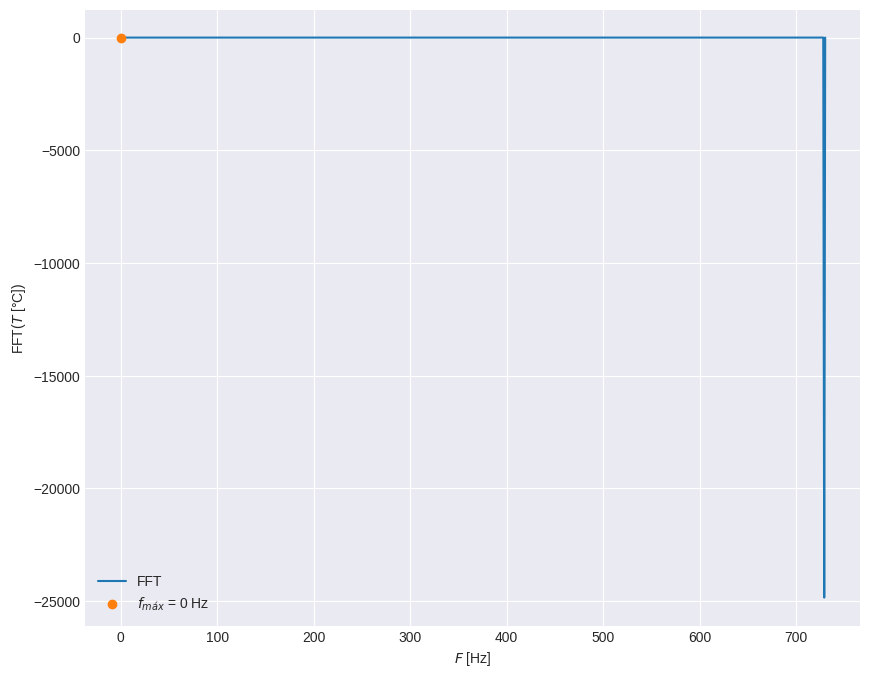

In [ ]:
# Visualizar FFT

plt.figure(figsize=(10,8))

plt.plot(mfft)
fmax, fmax_idx = (np.max(mfft), np.argmax(mfft))
plt.plot(fmax_idx, fmax, 'o');
plt.xlabel('$F$ [Hz]');
plt.ylabel('FFT($T$ [°C])');
plt.legend(['FFT', '$f_{máx}$ = ' + str(fmax_idx) + ' Hz']);

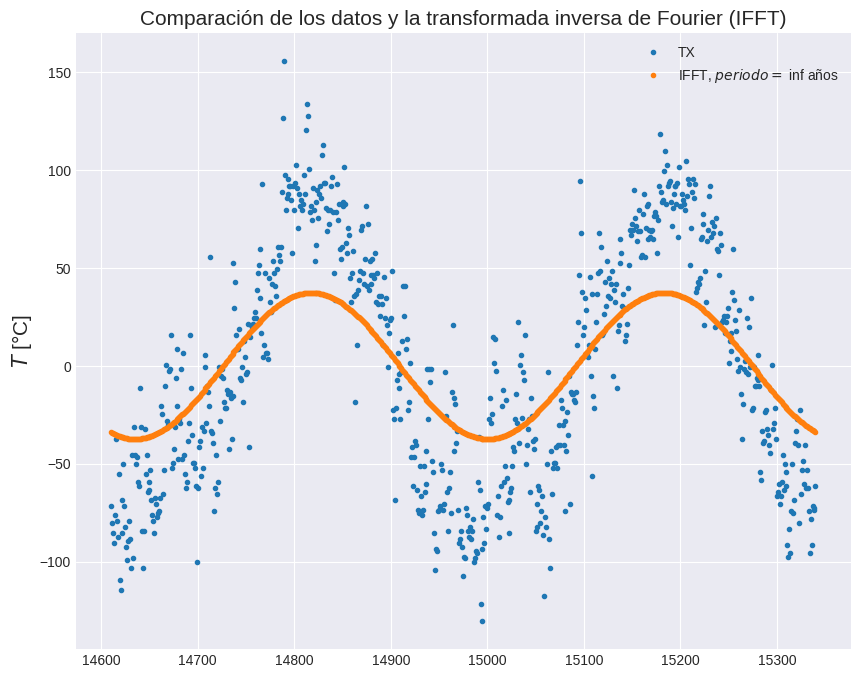

In [ ]:
# Visualizar transformada inversa del resultado anterior

fdata=np.fft.ifft(mfft) # Transformada inversa de Fourier
data = pd.Series(data, train.index)
fdata = pd.Series(fdata, train.index)
Tdata = 1/fmax_idx

plt.figure(figsize=(10,8))

data.plot(style='.')
fdata.plot(style='.', label='IFFT, $periodo =$ ' + str(round(Tdata, 2)) + ' años')
title = 'Comparación de los datos y la transformada inversa de Fourier (IFFT)'
plt.title(title, fontsize = 15);
plt.ylabel('$T$ [°C]', fontsize = 15);
plt.legend()
plt.show()

## Estimación de parámetros

Del proceso de reversión a la media con $\gamma = 0$ y tendencia funcional se tiene

\begin{equation}
  dX_t = \alpha(\mu(t) - X_t)dt + \sigma dB_t, \quad X_0=x
\end{equation}

donde $t \in [0,T]$, $\alpha>0$, $\sigma>0$, $\mu(t) \in \mathbb{R}$ con solución
\begin{align*}
  X_t &= \mu(t) + (X_0 - \mu(t))\exp[-\alpha t] + \sigma \exp[-\alpha t] \int_0^t \exp[\alpha s] dB_s\\
\end{align*}

### Estimación de $\alpha, \mu(t), \sigma$

Para estimar los parámetros se utilizan los estimadores

\begin{gather*}
  \hat{\mu}(t) = m(t) + \frac{\dot{m}(t)}{\hat{\alpha}}, \quad
  \hat{\alpha} = \frac{\sum_{i=1}^T\bigg[\big(X_i - X_{i-1} - \dot{m}_{i-1} \Delta t\big)\big(m_{i-1} - X_{i-1}\big)\bigg]}{\sum_{i=1}^T\bigg[\big(m_{i-1} - X_{i-1}\big)^2 \Delta t\bigg]}, \\
  \hat{\sigma} = \sqrt{\frac{1}{T \Delta t}\sum_{i=1}^T\Bigg[X_i - X_{i-1} - \big[\hat{\alpha}\big(m_{i-1}-X_{i-1}\big) + \dot{m}_{i-1}\big]\Delta t\Bigg]^2}
\end{gather*}

Donde

\begin{gather*}
  m_i = \sum_{k=-N}^N \frac{X_{i-k}}{2N+1}, \quad \dot{m}_i = \frac{2m_{i+1}-3m_i+m_{i-1}}{\Delta t}
\end{gather*}

In [ ]:
# Estimación de parámetros

p = len(train) # número de observaciones

dt = 1/p # Delta t

# mi con convolución de media móvil
# https://waterprogramming.wordpress.com/2018/09/04/implementation-of-the-moving-average-filter-using-convolution/#:~:text=A%20moving%20average%20is%20a,values%20in%20a%20moving%20window.
window = 31 # 31 por la estacionalidad dependiendo del mes del año, asumiendo 30 días + centro
mi = convolve(train,kernel=Box1DKernel(31)) # Equivalente a un filtro pasa bajas
mi = pd.Series(mi, index=train.index)
mi_dot = pd.Series(np.zeros(mi.shape), index=mi.index)

num = 0
den = 0

for i in range(1, p-1):
  mi_dot[i+14610] = (2*mi[i+1+14610] - 3*mi[i+14610] + mi[i-1+14610])/dt
  aux = mi[i-1+14610] - train[i-1+14610]

  num += (train[i+14610] - train[i-1+14610] - mi_dot[i-1+14610]*dt)*aux
  den += (mi[i-1+14610] - train[i-1+14610])**2 * dt

alpha_hat = num/den

sum = 0

for i in range(1, p-1):
  aux = mi[i-1+14610] - train[i-1+14610]
  sum += (train[i+14610] - train[i-1+14610] - (alpha_hat*(aux + mi_dot[i-1+14610])*dt))**2

sigma_hat = np.sqrt((1/(p*dt))*sum)

mu_hat = mi + mi_dot/alpha_hat

display(Math(r'\hat{\alpha} = ' + str(round(alpha_hat, 2))))
display(Math(r'\hat{\sigma} = ' + str(round(sigma_hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
train.index

Index([14610, 14611, 14612, 14613, 14614, 14615, 14616, 14617, 14618, 14619,
       ...
       15331, 15332, 15333, 15334, 15335, 15336, 15337, 15338, 15339, 15340],
      dtype='int64', length=731)

###  Reestimación de $\alpha, \mu(t), \sigma$

Para reestimar los parámetros se utilizan los estimadores

\begin{gather*}
  \hat{\hat{\mu}} = Y_t, \quad \hat{\hat{\alpha}} = \frac{\sum_{i=1}^T\Big[\big(X_i - X_{i-1}\big)\big(\hat{\hat{\mu}}_{i-1}-X_{i-1}\big)\Big]}{\sum_{i=1}^T\Big[\big(\hat{\hat{\mu}}_{i-1} - X_{i-1}\big)^2 \Delta t\Big]}, \quad \hat{\hat{\sigma}} = \sqrt{ \frac{1}{T \Delta t} \sum_{i=1}^T \Big[X_i - X_{i-1} - \hat{\hat{\alpha}}\big(\hat{\hat{\mu}}_{i-1}-X_{i-1}\big)\Delta t\Big]^2 }
\end{gather*}

Donde $Y_t = a + b\sin(\omega t)$ con $\omega = \frac{2\pi}{T}$ y sus parámetros se estiman por mínimos cuadrados

In [ ]:
omg = 2*np.pi/p

def Yt(t, a, b):
  model = a + b*np.sin(omg*t)
  return model

T = np.linspace(0, p, num = p) # Intervalo equiespaciado de tiempo

a, b = curve_fit(Yt, T, train.values)[0] # Mínimos cuadrados

mu_2hat = pd.Series(Yt(T, a, b), index=train.index)
mu_2hat

14610    232.367989
14611    232.371646
14612    232.375303
14613    232.378960
14614    232.382616
            ...    
15336    232.353362
15337    232.357017
15338    232.360674
15339    232.364331
15340    232.367989
Length: 731, dtype: float64

In [ ]:
omg = 2*np.pi/p

def Yt(t, a, b):
  model = a + b*np.sin(omg*t)
  return model

T = np.linspace(0, p, num = p) # Intervalo equiespaciado de tiempo

a, b = curve_fit(Yt, T, train.values)[0] # Mínimos cuadrados

mu_2hat = pd.Series(Yt(T, a, b), index=train.index)

aux = 0
num = 0
den = 0
for i in range(1, p-1):
  aux = mu_2hat[i-1+14610]-train[i-1+14610]
  num += (train[i+14610]-train[i-1+14610]*aux)
  den += aux**2*dt

alpha_2hat = num/den

aux = 0
sum = 0
for i in range(1, p-1):
  aux = mu_2hat[i-1+14610]-train[i-1+14610]
  sum += (train[i+14610]-train[i-1+14610]-alpha_2hat*aux*dt)**2

sigma_2hat = (1/(p*dt))*sum

display(Math(r'\hat{\hat{\alpha}} = ' + str(round(alpha_2hat, 2))))
display(Math(r'\hat{\hat{\sigma}} = ' + str(round(sigma_2hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Simulación del modelo resultante

Despues de realizar la estimación y reestimación de los parámetros se procede a simular el proceso. Aplicando la aproximación numérica de Euler-Maruyama a la solución analítica del proceso se obtiene

\begin{align*}
  X(t) &= \hat{\hat{\mu}}(t) + (X(t-1) - \hat{\hat{\mu}}(t))\exp[-\hat{\hat{\alpha}} \Delta t] + \hat{\hat{\sigma}} \exp[-\hat{\hat{\alpha}} \Delta t] \Delta B_t
\end{align*}

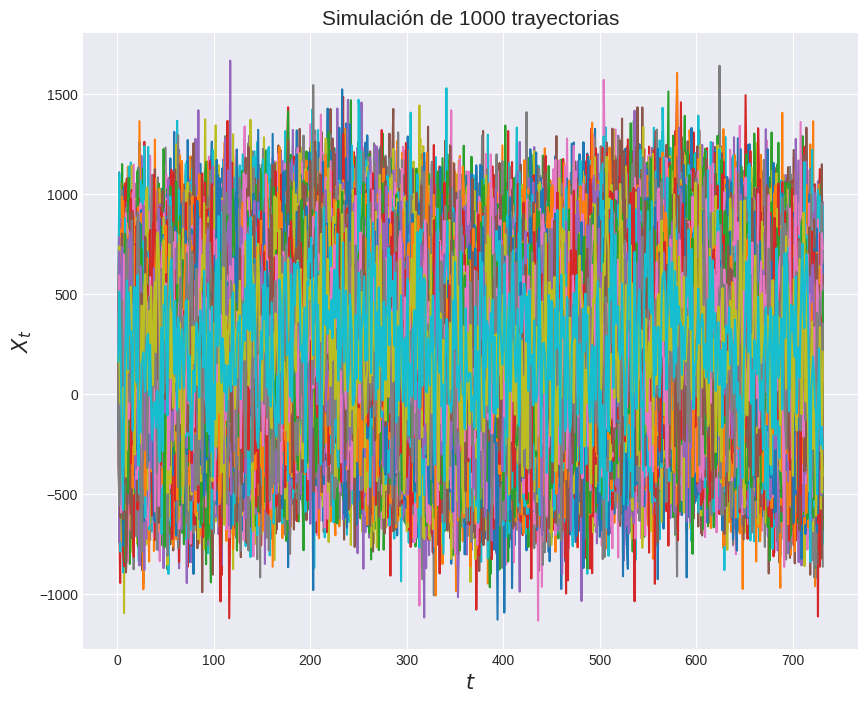

In [ ]:
# Simulación

l = 1000 # número de simulaciones
p = len(train) # número de observaciones

X = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

mu = mu_hat
alpha = alpha_2hat
sigma = sigma_hat

X0 = train[14610] # Valor inicial

plt.figure(figsize=(10,8))
for sim in range(l): # Ciclo de simulaciones
  X[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X[sim, t] = mu[t+14610] + (X[sim, t-1] - mu[t+14610])*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt
  plt.plot(p*T, X[sim]);

title = 'Simulación de ' + str(l) + r' trayectorias'
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$X_t$', fontsize = 15);

## Pronóstico

In [ ]:
l = 1000 # número de simulaciones
p = len(test) # número de observaciones

X_hat = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

mu = mu_hat
alpha = alpha_2hat
sigma = sigma_hat

X0 = train[14610]  # Valor inicial

for sim in range(l): # Ciclo de simulaciones
  X_hat[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat[sim, t] = mu[t+14610-1] + (X_hat[sim, t-1] - mu[t+14610-1])*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt

In [ ]:
len(X_hat.mean(axis=0).values)

732

Text(0.5, 1.0, 'Prónostico de temperatura máxima diaria 2021-2023')

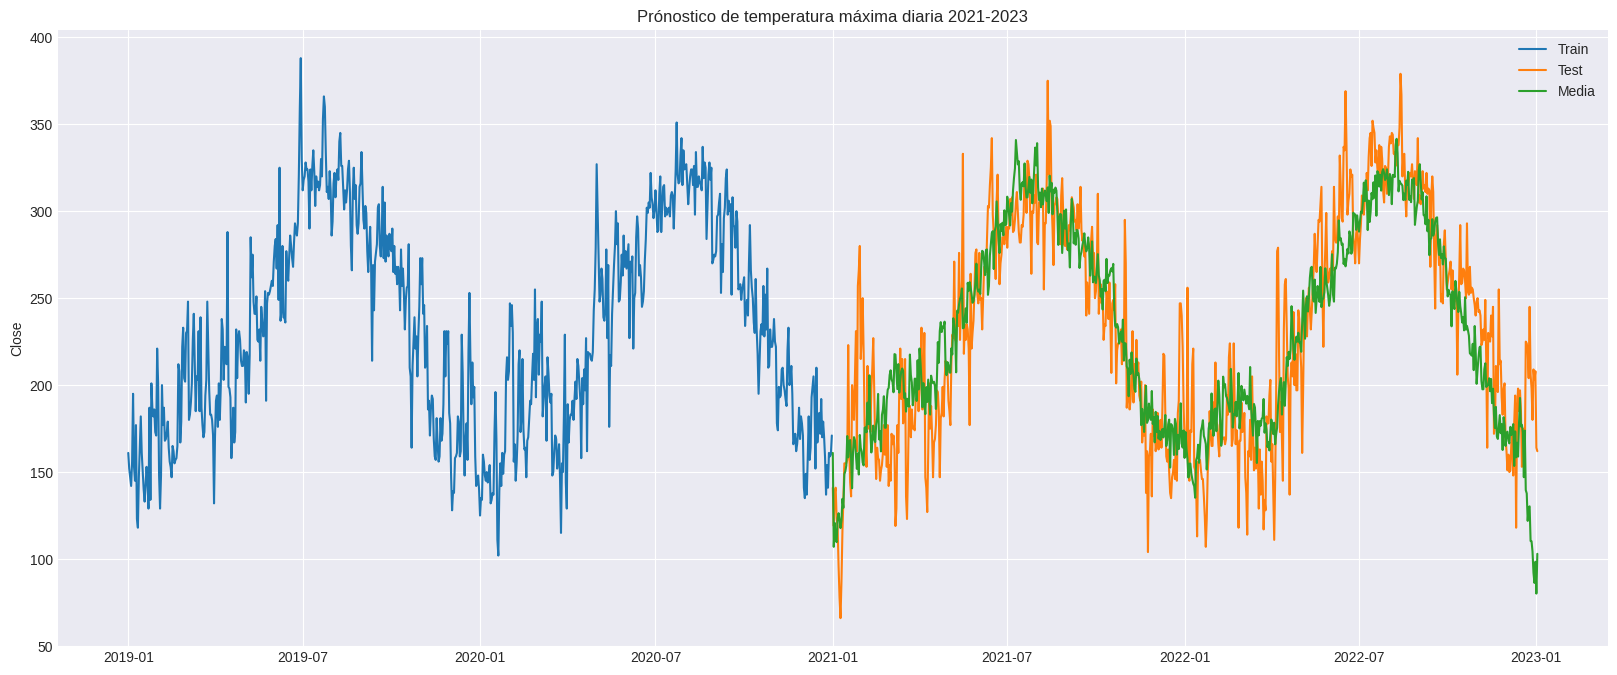

In [ ]:
# Visualizar
fig1 = plt.figure(figsize=(20,8))
plt.plot(data1['DATE'],data1['TX'])
#train.plot()
#test.plot(title='Pronóstico de la Temperatura promedio diaria (°C) de 2019 a 2021');

X_hat = pd.DataFrame(X_hat)
X_hat_mean = pd.Series(X_hat.mean(axis=0).values, index=test.index)
#X_hat_mean.plot(style='--', color='#BD162C');
X_hat_median = pd.Series(X_hat.quantile(q=0.5, axis=0).values, index=test.index)
#X_hat_median.plot(style='--', color='#3743ad');
plt.plot(data2['DATE'],data2['TX'])
plt.plot(data2['DATE'],X_hat_mean)


# Bandas de confianzas
X_hat_hi = pd.Series(X_hat.quantile(q=0.55, axis=0).values, index=test.index)
# X_hat_hi.plot(style='--', color='black');
X_hat_lo = pd.Series(X_hat.quantile(q=0.45, axis=0).values, index=test.index)
# X_hat_lo.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Train','Test', 'Media', 'Mediana']);
plt.title("Prónostico de temperatura máxima diaria 2021-2023")
